In [1]:
import math
import torch
import torchvision
import numpy as np
from torch import nn
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [2]:
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

for X, y in test_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([256, 1, 28, 28]) torch.float32 torch.Size([256]) torch.int64
torch.Size([256, 1, 28, 28]) torch.float32 torch.Size([256]) torch.int64


In [3]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

In [4]:
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [5]:
## ReLU
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [6]:
def net(X):
    X = X.view(-1, num_inputs)
    H = relu(X@W1 + b1)
    return (H@W2 + b2)

In [7]:
loss = nn.CrossEntropyLoss(reduction='none')

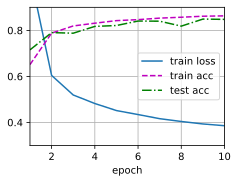

In [8]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

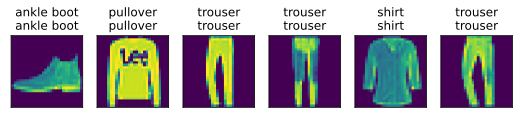

In [9]:
d2l.predict_ch3(net, test_iter)

---

In [10]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

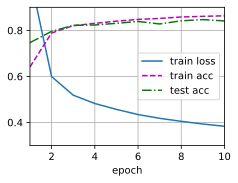

In [11]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

---

In [12]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [13]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.4747],
         [ 0.4298]]),
 tensor([[ 1.0000e+00, -4.7474e-01,  1.1269e-01, -1.7833e-02,  2.1165e-03,
          -2.0096e-04,  1.5901e-05, -1.0784e-06,  6.3997e-08, -3.3758e-09,
           1.6026e-10, -6.9167e-12,  2.7364e-13, -9.9930e-15,  3.3887e-16,
          -1.0725e-17,  3.1823e-19, -8.8868e-21,  2.3439e-22, -5.8565e-24],
         [ 1.0000e+00,  4.2984e-01,  9.2381e-02,  1.3236e-02,  1.4224e-03,
           1.2228e-04,  8.7600e-06,  5.3791e-07,  2.8902e-08,  1.3804e-09,
           5.9333e-11,  2.3185e-12,  8.3049e-14,  2.7460e-15,  8.4309e-17,
           2.4160e-18,  6.4905e-20,  1.6411e-21,  3.9189e-23,  8.8658e-25]]),
 tensor([3.9390, 5.3676]))

In [14]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [15]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]

    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.993361   1.1962649 -3.3957064  5.613449 ]]


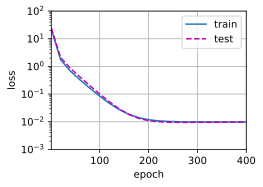

In [16]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.1263494 3.5259788]]


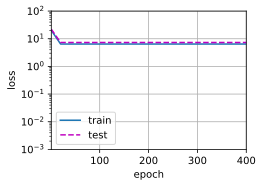

In [17]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9617453   1.2767562  -3.2543738   5.1718802  -0.40678382  1.3003267
   0.05530558  0.2357618  -0.0295501  -0.06786373  0.12341887 -0.04767522
   0.15585563  0.1029593  -0.03564348  0.22237585 -0.12813962 -0.16567972
  -0.1882245   0.0473873 ]]


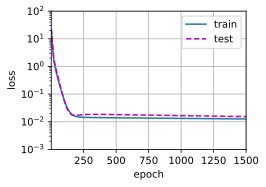

In [18]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)